# Machine Learning Boilerplate Workflow (Logistic Regression Example)

## 1. Define Problem
**Goal:** Predict whether a tumor is Malignant (1) or Benign (0) using medical features.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

## 2. Load & Inspect Data

In [3]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [4]:
print("Shape of features:", X.shape)
print("Class distribution:\n", y.value_counts())

Shape of features: (569, 30)
Class distribution:
 1    357
0    212
Name: count, dtype: int64


## 3. EDA

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

                 count        mean         std        min        25%  \
mean radius      569.0   14.127292    3.524049    6.98100   11.70000   
mean texture     569.0   19.289649    4.301036    9.71000   16.17000   
mean perimeter   569.0   91.969033   24.298981   43.79000   75.17000   
mean area        569.0  654.889104  351.914129  143.50000  420.30000   
mean smoothness  569.0    0.096360    0.014064    0.05263    0.08637   

                       50%       75%        max  
mean radius       13.37000   15.7800    28.1100  
mean texture      18.84000   21.8000    39.2800  
mean perimeter    86.24000  104.1000   188.5000  
mean area        551.10000  782.7000  2501.0000  
mean smoothness    0.09587    0.1053     0.1634  


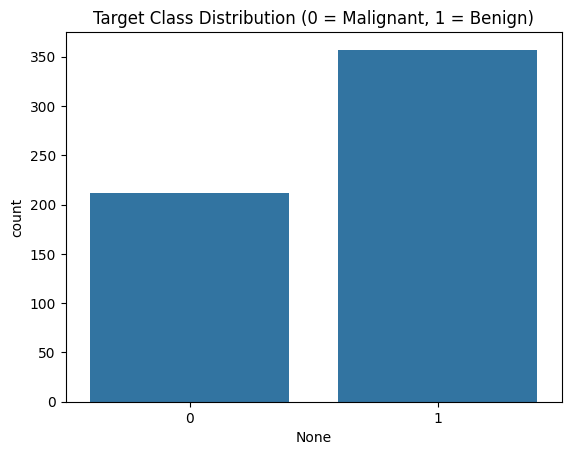

In [6]:
print(X.describe().T.head())  # summary statistics
sns.countplot(x=y)
plt.title("Target Class Distribution (0 = Malignant, 1 = Benign)")
plt.show()

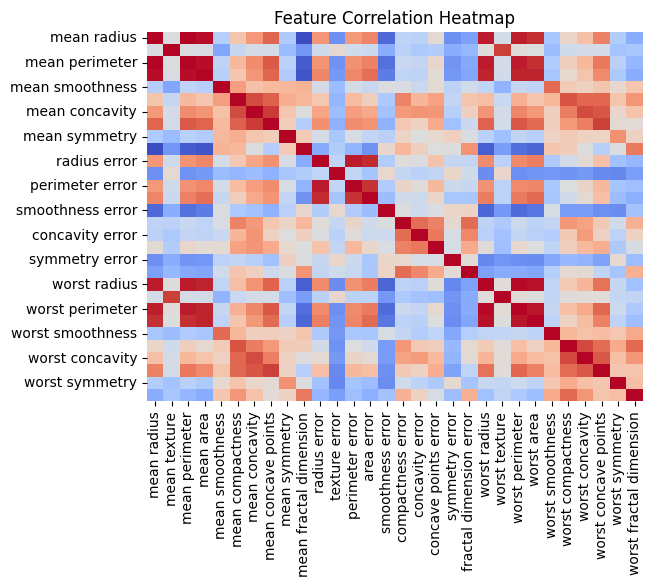

In [7]:
# Correlation Heatmap (top features)
corr = X.corr()
sns.heatmap(corr, cmap="coolwarm", cbar=False)
plt.title("Feature Correlation Heatmap")
plt.show()

## 4. Data Preparation

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Train Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
log_reg = LogisticRegression(max_iter=500, solver="lbfgs")
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500)

In [12]:
print("Training Accuracy:", log_reg.score(X_train_scaled, y_train))
print("Test Accuracy:", log_reg.score(X_test_scaled, y_test))

Training Accuracy: 0.989010989010989
Test Accuracy: 0.9824561403508771


## 6. Gradient Descent (conceptual demo)
- Logistic regression in sklearn uses gradient descent under the hood. Here’s a simple demonstration with one feature.

In [13]:
from sklearn.datasets import make_classification

In [14]:
X_demo, y_demo = make_classification(n_samples=100, n_features=1, n_informative=1,
                                     n_redundant=0, n_clusters_per_class=1, random_state=42)

In [15]:
# Sigmoid function
sigmoid = lambda z: 1 / (1 + np.exp(-z))

weights = 0.0
lr = 0.1
for i in range(100):
    z = X_demo.flatten() * weights
    predictions = sigmoid(z)
    gradient = np.dot(X_demo.flatten(), (y_demo - predictions)) / len(y_demo)
    weights += lr * gradient

print("Final demo weight after gradient descent:", weights)

Final demo weight after gradient descent: 2.0621362250056507


## 7. Evaluate Model (Classification Metrics)

In [16]:
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, log_loss, precision_score, recall_score, f1_score)

In [17]:
# Predictions
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

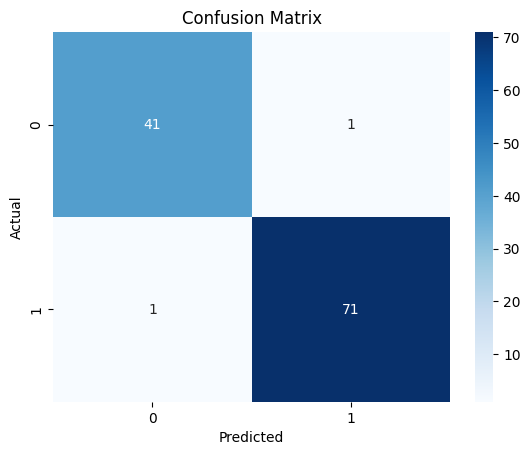

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [19]:
# Precision, Recall, F1, Accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [20]:
# Sensitivity = Recall for positive class (malignant)
sensitivity = recall_score(y_test, y_pred)
# Specificity = TN / (TN + FP)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

Sensitivity (Recall): 0.9861111111111112
Specificity: 0.9761904761904762


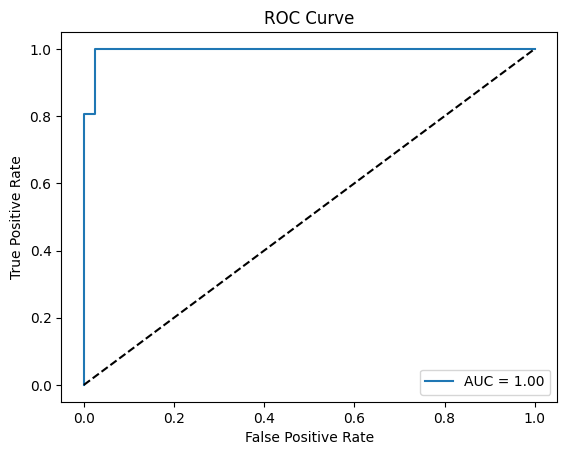

In [21]:
# ROC/AUC
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [22]:
# Log-Loss
print("Log Loss:", log_loss(y_test, y_pred_proba))

Log Loss: 0.07787101522018894


## 8. Cross-Validation

In [23]:
from sklearn.model_selection import cross_val_score

In [24]:
cv_scores = cross_val_score(log_reg, X, y, cv=5, scoring="accuracy")
print("Cross-validation Accuracy:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-validation Accuracy: [0.93859649 0.93859649 0.97368421 0.94736842 0.96460177]
Mean CV Accuracy: 0.9525694767893185


## 9. Regularization & Hyperparameter Tuning

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
params = {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"]}

log_reg_cv = GridSearchCV(LogisticRegression(max_iter=500, solver="lbfgs"),
                          param_grid=params, cv=5, scoring="accuracy")
log_reg_cv.fit(X_train_scaled, y_train)

print("Best Params:", log_reg_cv.best_params_)
print("Best CV Score:", log_reg_cv.best_score_)

Best Params: {'C': 0.1, 'penalty': 'l2'}
Best CV Score: 0.9802197802197803


## 10. Bias-Variance Tradeoff (Learning Curve)

In [27]:
from sklearn.model_selection import learning_curve

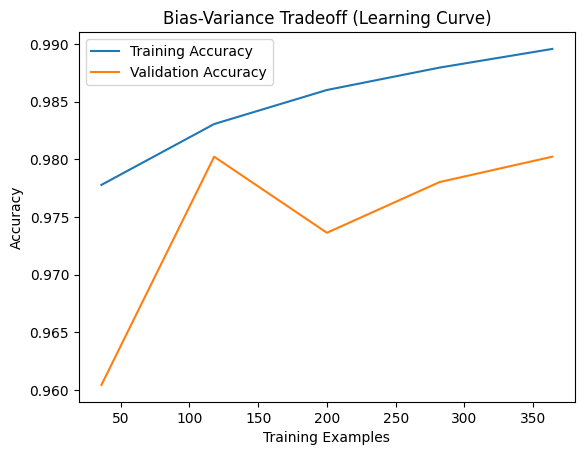

In [28]:
train_sizes, train_scores, test_scores = learning_curve(
    log_reg, X_train_scaled, y_train, cv=5, scoring="accuracy", n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Validation Accuracy")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.title("Bias-Variance Tradeoff (Learning Curve)")
plt.legend()
plt.show()

## 11. Interpret Coefficients (Odds Ratios)

In [29]:
coefs = pd.DataFrame({"Feature": data.feature_names,
                      "Coefficient": log_reg.coef_[0],
                      "Odds Ratio": np.exp(log_reg.coef_[0])})
print(coefs.sort_values(by="Odds Ratio", ascending=False).head())

                    Feature  Coefficient  Odds Ratio
5          mean compactness     0.653627    1.922501
15        compactness error     0.642724    1.901653
19  fractal dimension error     0.435616    1.545915
18           symmetry error     0.358784    1.431588
11            texture error     0.251148    1.285500


## 12. Save Model

In [30]:
import joblib

joblib.dump(log_reg, "logistic_regression_model.pkl")
print("Model saved as logistic_regression_model.pkl")

Model saved as logistic_regression_model.pkl
